In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.strategies import *
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
torch.cuda.device_count()

4

In [3]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40338MB, multi_processor_count=108)

In [4]:
# Define the LightningModule
class CIFAR10ResNet(pl.LightningModule):
    def __init__(self, learning_rate=1e-2):
        super().__init__()
        self.save_hyperparameters()
        self.model = resnet18(num_classes=10)
        self.learning_rate = learning_rate
        self.validation_start_time = None  # To track time for validation

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
    
    def on_validation_epoch_start(self):
        self.validation_start_time = time.time()

    def on_validation_epoch_end(self):
        elapsed_time = time.time() - self.validation_start_time
        self.log('val_time', elapsed_time, prog_bar=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [21]:
# Function to train with 1 or 4 GPUs and log metrics
def train_model(gpu_count, log_name):
    # Data Preparation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    dataset = CIFAR10(root='data', train=True, download=True, transform=transform)
    train_data, val_data = random_split(dataset, [45000, 5000])
    train_loader = DataLoader(train_data, batch_size=64, num_workers=4, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64, num_workers=4, shuffle=False)

    # Logger and checkpoint
    csv_logger = CSVLogger("logs", name=log_name)
    checkpoint_callback = ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1)

    # Model Training
    model = CIFAR10ResNet()
    trainer = Trainer(
        max_epochs=20, 
        accelerator="gpu", 
        devices=gpu_count,  # Set number of GPUs
        strategy="fsdp" if gpu_count > 1 else "auto",  # Data Parallel (dp) if using more than 1 GPU
        logger=csv_logger, 
        callbacks=[checkpoint_callback]
    )
    trainer.fit(model, train_loader, val_loader)

    # Return CSV log path for further analysis
    return csv_logger.experiment.metrics_file_path

Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/global/common/software/nersc9/pytorch/2.3.1/lib/python3.11/site-packages/torch/distributed/fsdp/_init_utils.py:437: UserWarning: FSDP is switching to use `NO_SHARD` instead of ShardingStrategy.FULL_SHARD since the world size is 1.
  warnings.warn(

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/global/common/software/nersc9/pytorch/2.3.1/lib/python3.11/site-packages/torch/distributed/fsdp/_state_dict_utils.py:772: UserWarning: When using ``NO_SHARD`` for ``ShardingStrategy``, full_state_dict willbe returned.
  warnings.warn(
/global/common/software/nersc9/pytorch/2.3.1/lib/python3.11/site-packages/torch/distributed/fsdp/_state_dict_utils.py:715: UserWarning: When using ``NO_SHARD`` for ``ShardingStrategy``, full_state_dict willbe returned.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


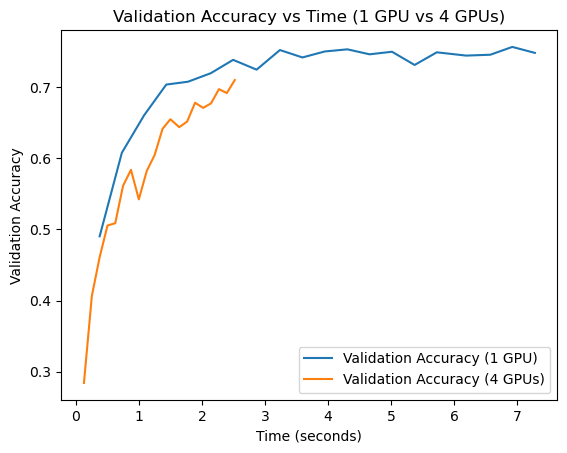

In [25]:
# Train using 1 GPU
log_file_1_gpu = train_model(gpu_count=1, log_name="cifar10_resnet18_1_gpu")

# Train using 4 GPUs (assuming system has 4 GPUs)
log_file_4_gpu = train_model(gpu_count=4, log_name="cifar10_resnet18_4_gpu")

# Load data from log files
data_1_gpu = pd.read_csv(log_file_1_gpu).dropna(subset=['val_acc'])
data_4_gpu = pd.read_csv(log_file_4_gpu).dropna(subset=['val_acc'])

# Plot Validation Accuracy vs Time for 1 and 4 GPUs
plt.figure()

# Cumulative validation times for 1 GPU
val_times_1_gpu = data_1_gpu['val_time'].cumsum()
plt.plot(val_times_1_gpu, data_1_gpu['val_acc'], label='Validation Accuracy (1 GPU)')

# Cumulative validation times for 4 GPUs
val_times_4_gpu = data_4_gpu['val_time'].cumsum()
plt.plot(val_times_4_gpu, data_4_gpu['val_acc'], label='Validation Accuracy (4 GPUs)')

plt.xlabel('Time (seconds)')
plt.ylabel('Validation Accuracy')
plt.legend(loc='best')
plt.title('Validation Accuracy vs Time (1 GPU vs 4 GPUs)')
plt.savefig('val_acc_data_parallel.png')
